<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Gen_Chars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Chars Generator

In [ ]:
import torch
from torch import nn
from torch.nn import RNN, LSTM, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

In [ ]:
FILE = "lstb.txt"
with open(FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

7841

In [ ]:
translator = str.maketrans('', '', string.punctuation)

In [ ]:
import re

with open(FILE, "r") as f:
  text = f.read()
  text = text.strip().translate(translator).lower()
  text = text[:int(len(text)*0.05) + 1]
  print(text.count("\n") + 1)

# print(f"Before: {len(text)}")

# text = re.sub('\)', '',text)
# text = re.sub('\(', '',text)

# for pattern in set(re.findall('<unk>', text)):
#   text = re.sub(pattern, '', text)

# print(f"After: {len(text)}")

408


In [ ]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [ ]:
# Tokenize
tokens = []
for i in text:
  tokens.append(i)

tokens = list(set(tokens))
vocab_size = len(tokens)
sorted(tokens), vocab_size

(['\n',
  ' ',
  '1',
  '2',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'à',
  'ê'],
 34)

In [ ]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [ ]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  for i in arr:
    for j in range(len(i)):
      i[j] = token_to_indx[i[j]]
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr

In [ ]:
SEQ_LENGTH = 10

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH = SEQ_LENGTH, STEP=1):
  for i in range(0, len(text)- SEQ_LENGTH, STEP):
    chars = []
    for j in range(i + SEQ_LENGTH):
      chars.append(text[j])
    X.append(chars)
    y.append([text[i+SEQ_LENGTH]])
  return X, y

In [ ]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

X_test[1], y_test[1]

(['w', ' ', 't', 'r', 'i', 'f', 'l', 'i', 'n', 'g', ' '], ['p'])

In [ ]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [ ]:
X_test = encode(X_test)
y_test = encode(y_test)

In [ ]:
# Padding X and y
X_train_padded = pad_sequences(X_train, maxlen=10, padding='post', value=0)  # 'post' means pad at the end of each sequence
y_train_padded = pad_sequences(y_train, maxlen=10, padding='post', value=0)

X_test_padded = pad_sequences(X_test, maxlen=10, padding='post', value=0)
y_test_padded = pad_sequences(y_test, maxlen=10, padding='post', value=0)

In [ ]:
print(f"X Shape: {X_train_padded.shape} | y shape: {y_train_padded.shape}")

X Shape: (15404, 10) | y shape: (15404, 10)


In [ ]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train_padded, num_classes=vocab_size)

In [ ]:
X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test_padded, num_classes=vocab_size)

In [ ]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 3
X Shape: (15404, 10, 34) | y shape: (15404, 10, 34)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

# TensorFlow Based

In [139]:
model = Sequential()
model.add(keras.layers.Input(shape=(41, X_train_cat.shape[2])))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [140]:
history = model.fit(X_train_cat, y_train_cat, epochs=5, verbose=1)

Epoch 1/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8741 - loss: 0.8774
Epoch 2/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9234 - loss: 0.2904
Epoch 3/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9247 - loss: 0.2834
Epoch 4/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9246 - loss: 0.2818
Epoch 5/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9243 - loss: 0.2818


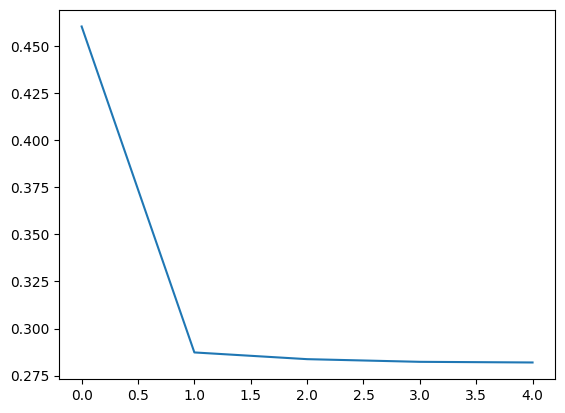

In [141]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [142]:
# Model structure
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)                  │ (None, 41, 34)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 41, 128)             │          83,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 41, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 41, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 41, 34)              │           2,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,704 (1.59 MB)

 Trainable params: 139,234 (543.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,470 (1.06 MB)

In [158]:
input_string = [["say my nam"]]

def convert(string):
  input_string = [i for i in string[0][0]]
  input_string_arr = [token_to_indx[i] for i in input_string]
  input_string_arr = pad_sequences([input_string_arr], maxlen=10, padding="pre", value=0)
  print(input_string_arr)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)
print(input_string_arr)

y_preds = model.predict(input_string_arr)
print(y_preds, y_preds.shape)

probabilities = tf.argmax(tf.nn.softmax(y_preds), axis=1)
print(probabilities)
input_string[0].append(indx_to_token[int(probabilities[0][0])])
print(input_string)
print("".join(input_string[0]))

[[ 7 19 18 26 27 18 26 33 19 27]]
[[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0

In [ ]:
input_string = [["say my nam"]]
[i for i in input_string[0][0]]

['s', 'a', 'y', ' ', 'm', 'y', ' ', 'n', 'a', 'm']

In [160]:
loop_string = [["say my nam"]]
arr_input = convert(loop_string)

def predict_loop(string_input, arr_input, output_length):
  for i in range(output_length):
    print(i)
    y_preds = model.predict(arr_input)
    probabilities = tf.argmax(tf.nn.softmax(y_preds), axis=1)
    string_input[0].append(indx_to_token[int(probabilities[0][0])])
    string_input = [["".join(string_input[0])]]
    new_string = [[string_input[0][0][i + 1:]]]
    print(new_string)
    arr_input = convert(new_string)


[[ 7 19 18 26 27 18 26 33 19 27]]


In [ ]:
predict_loop(loop_string, arr_input, 10)

In [159]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9243 - loss: 0.2781


[0.27825024724006653, 0.9244277477264404]

In [ ]:
model.save("model_0.keras")